**English WSD Preprocessing and train test split**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [33]:
df1 = pd.read_csv("English.csv")
selected_columns = df.iloc[:, [0,1, 6, 7, 8]]
selected_columns

,Column1,Column2,Column7,Column8,Column9
0,approach,V,Approach a task.,To approach the city.,0
1,summer,V,We like to summer in the Mediterranean.,We summered in Kashmir.,1
2,meet,V,The company agrees to meet the cost of any rep...,This proposal meets my requirements.,1
3,development,N,The organism has reached a crucial stage in it...,Our news team brings you the latest developments.,0
4,narrowness,N,The problem with achievement tests is the narr...,Frustrated by the narrowness of people's horiz...,1
...,...,...,...,...,...
5423,round,N,He ordered a second round.,They brought us a round of drinks about every ...,1
5424,run,N,The team enjoyed a brief run of victories.,"Yesterday we did a run of 12,000 units.",0
5425,charge,V,Can I charge this purchase?,The suspect was charged with murdering his wife.,0
5426,catch,V,Catch one's breath.,I caught the hem of my dress in the brambles.,0


In [14]:
# Extract the columns from the DataFrame
train_word = df["Column1"].tolist()
train_context1 = df["Column7"].astype(str).tolist()
train_context2 = df["Column8"].astype(str).tolist()
train_label = np.array(df["Column9"].tolist())

# Prepare input and output data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_context1 + train_context2)

word_index = tokenizer.word_index

train_context1_seq = tokenizer.texts_to_sequences(train_context1)
train_context2_seq = tokenizer.texts_to_sequences(train_context2)

max_len = 30
train_context1_seq = pad_sequences(train_context1_seq, maxlen=max_len, padding="post", truncating="post")
train_context2_seq = pad_sequences(train_context2_seq, maxlen=max_len, padding="post", truncating="post")

train_input = np.concatenate((train_context1_seq, train_context2_seq), axis=1)

num_classes = 2
train_output = tf.keras.utils.to_categorical(train_label, num_classes)

# Train-validation split
train_input, val_input, train_output, val_output = train_test_split(train_input, train_output, test_size=0.33, random_state=42)

**Bi-LSTM-English**

In [15]:
# Build the BiLSTM model
input_shape = (2 * max_len,)
embedding_dim = 64
lstm_units = 128

BiLSTM_english = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiLSTM_english.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiLSTM_english.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiLSTM_english_loss, BiLSTM_english_accuracy = BiLSTM_english.evaluate(val_input, val_output)
print(f"BiLSTM_english Loss  : {BiLSTM_english_loss}, BiLSTM_english Accuracy: {BiLSTM_english_accuracy}")


Epoch 1/10
114/114 [==============================] - 14s 94ms/step - loss: 0.6908 - accuracy: 0.5366 - val_loss: 0.6808 - val_accuracy: 0.5692
Epoch 2/10
114/114 [==============================] - 11s 99ms/step - loss: 0.5814 - accuracy: 0.7016 - val_loss: 0.7197 - val_accuracy: 0.5893
Epoch 3/10
114/114 [==============================] - 13s 113ms/step - loss: 0.4242 - accuracy: 0.8075 - val_loss: 0.7770 - val_accuracy: 0.5960
Epoch 4/10
114/114 [==============================] - 11s 99ms/step - loss: 0.3178 - accuracy: 0.8592 - val_loss: 0.9772 - val_accuracy: 0.5993
Epoch 5/10
114/114 [==============================] - 12s 104ms/step - loss: 0.2524 - accuracy: 0.8853 - val_loss: 0.9623 - val_accuracy: 0.5949
Epoch 6/10
114/114 [==============================] - 12s 103ms/step - loss: 0.2021 - accuracy: 0.9153 - val_loss: 1.1906 - val_accuracy: 0.5871
Epoch 7/10
114/114 [==============================] - 13s 112ms/step - loss: 0.1430 - accuracy: 0.9466 - val_loss: 1.3742 - val_accur

In [40]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'embedding_dim': [32, 64, 128],
    'lstm_units': [64, 128, 256],
}

# Define the model
def create_model(embedding_dim, lstm_units):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_shape=input_shape),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Create the Keras classifier
keras_classifier = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)

# Create the GridSearchCV instance
grid_search = GridSearchCV(
    estimator=keras_classifier,
    param_grid=param_grid,
    cv=3,  # Number of cross-validation folds
    verbose=1
)

# Perform the grid search
grid_search.fit(train_input, train_output)

# Print the best parameters and results
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)


C:\Users\pranc\AppData\Local\Temp\ipykernel_14860\2253339293.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = tf.keras.wrappers.scikit_learn.KerasClassifier(create_model)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
114/114 [==============================] - 22s 156ms/step - loss: 0.6870 - accuracy: 0.5407
Best parameters:  {'embedding_dim': 128, 'lstm_units': 128}
Best accuracy:  0.5731573104858398


In [41]:
from tensorflow.keras import regularizers

# Build the BiLSTM model with L2 regularization
BiLSTM_english = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, kernel_regularizer=regularizers.l2(0.01))),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiLSTM_english.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiLSTM_english.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiLSTM_english_loss, BiLSTM_english_accuracy = BiLSTM_english.evaluate(val_input, val_output)
print(f"BiLSTM_english Loss: {BiLSTM_english_loss}, BiLSTM_english Accuracy: {BiLSTM_english_accuracy}")


Epoch 1/10
114/114 [==============================] - 25s 176ms/step - loss: 1.2759 - accuracy: 0.5044 - val_loss: 0.7150 - val_accuracy: 0.5547
Epoch 2/10
114/114 [==============================] - 19s 170ms/step - loss: 0.6612 - accuracy: 0.6408 - val_loss: 0.6828 - val_accuracy: 0.5893
Epoch 3/10
114/114 [==============================] - 20s 173ms/step - loss: 0.5112 - accuracy: 0.7827 - val_loss: 0.7735 - val_accuracy: 0.5804
Epoch 4/10
114/114 [==============================] - 20s 175ms/step - loss: 0.3880 - accuracy: 0.8391 - val_loss: 0.8642 - val_accuracy: 0.5876
Epoch 5/10
114/114 [==============================] - 20s 173ms/step - loss: 0.3198 - accuracy: 0.8721 - val_loss: 0.9851 - val_accuracy: 0.6004
Epoch 6/10
114/114 [==============================] - 21s 181ms/step - loss: 0.2782 - accuracy: 0.8804 - val_loss: 0.9483 - val_accuracy: 0.5831
Epoch 7/10
114/114 [==============================] - 20s 174ms/step - loss: 0.2568 - accuracy: 0.8892 - val_loss: 1.0720 - val_ac

In [43]:
from tensorflow.keras import regularizers

# Build the BiLSTM model with L2 regularization
BiLSTM_english = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, kernel_regularizer=regularizers.l2(0.1))),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiLSTM_english.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiLSTM_english.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiLSTM_english_loss, BiLSTM_english_accuracy = BiLSTM_english.evaluate(val_input, val_output)
print(f"BiLSTM_english Loss: {BiLSTM_english_loss}, BiLSTM_english Accuracy: {BiLSTM_english_accuracy}")


Epoch 1/10
114/114 [==============================] - 23s 167ms/step - loss: 6.4805 - accuracy: 0.4989 - val_loss: 0.9119 - val_accuracy: 0.5011
Epoch 2/10
114/114 [==============================] - 18s 159ms/step - loss: 0.7406 - accuracy: 0.5366 - val_loss: 0.7522 - val_accuracy: 0.5223
Epoch 3/10
114/114 [==============================] - 19s 168ms/step - loss: 0.7087 - accuracy: 0.6469 - val_loss: 0.7107 - val_accuracy: 0.5725
Epoch 4/10
114/114 [==============================] - 19s 170ms/step - loss: 0.5873 - accuracy: 0.7305 - val_loss: 0.7117 - val_accuracy: 0.5938
Epoch 5/10
114/114 [==============================] - 19s 163ms/step - loss: 0.4681 - accuracy: 0.8116 - val_loss: 0.7974 - val_accuracy: 0.5798
Epoch 6/10
114/114 [==============================] - 18s 162ms/step - loss: 0.3820 - accuracy: 0.8487 - val_loss: 0.8858 - val_accuracy: 0.6105
Epoch 7/10
114/114 [==============================] - 18s 162ms/step - loss: 0.3192 - accuracy: 0.8804 - val_loss: 0.9748 - val_ac

**Bi-GRU-English**

In [16]:
# Build the BiGRU model
input_shape = (2 * max_len,)
embedding_dim = 64
gru_units = 128

BiGru_english = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiGru_english.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiGru_english.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiGru_english_loss, BiGru_english_accuracy = BiGru_english.evaluate(val_input, val_output)
print(f"Validation Loss: {BiGru_english_loss}, Validation Accuracy: {BiGru_english_accuracy}")

Epoch 1/10
114/114 [==============================] - 18s 106ms/step - loss: 0.6864 - accuracy: 0.5338 - val_loss: 0.6731 - val_accuracy: 0.5759
Epoch 2/10
114/114 [==============================] - 11s 97ms/step - loss: 0.5980 - accuracy: 0.7162 - val_loss: 0.7051 - val_accuracy: 0.5915
Epoch 3/10
114/114 [==============================] - 12s 109ms/step - loss: 0.4221 - accuracy: 0.8102 - val_loss: 0.8222 - val_accuracy: 0.5926
Epoch 4/10
114/114 [==============================] - 11s 93ms/step - loss: 0.2966 - accuracy: 0.8666 - val_loss: 0.9512 - val_accuracy: 0.5887
Epoch 5/10
114/114 [==============================] - 11s 100ms/step - loss: 0.2228 - accuracy: 0.9043 - val_loss: 1.1732 - val_accuracy: 0.5921
Epoch 6/10
114/114 [==============================] - 11s 97ms/step - loss: 0.1846 - accuracy: 0.9175 - val_loss: 1.3412 - val_accuracy: 0.5960
Epoch 7/10
114/114 [==============================] - 11s 95ms/step - loss: 0.1429 - accuracy: 0.9428 - val_loss: 1.5577 - val_accura

In [19]:
# Load the test dataset
test_data = pd.read_csv("val.csv")
test_context1 = test_data["Column7"].astype(str).tolist()
test_context2 = test_data["Column8"].astype(str).tolist()

# Tokenize and preprocess the test data
test_context1_seq = tokenizer.texts_to_sequences(test_context1)
test_context2_seq = tokenizer.texts_to_sequences(test_context2)

test_context1_seq = pad_sequences(test_context1_seq, maxlen=max_len, padding="post", truncating="post")
test_context2_seq = pad_sequences(test_context2_seq, maxlen=max_len, padding="post", truncating="post")

test_input = np.concatenate((test_context1_seq, test_context2_seq), axis=1)

# Predict on the test data using the BiLSTM model
BiLSTM_predictions = BiLSTM_english.predict(test_input)
BiLSTM_predicted_labels = np.argmax(BiLSTM_predictions, axis=1)

# Predict on the test data using the BiGRU model
BiGRU_predictions = BiGru_english.predict(test_input)
BiGRU_predicted_labels = np.argmax(BiGRU_predictions, axis=1)

# Append predicted labels to the dataframe
test_data["BiLSTM_Predicted_Labels"] = BiLSTM_predicted_labels
test_data["BiGRU_Predicted_Labels"] = BiGRU_predicted_labels

# Print the updated dataframe
test_data


20/20 [==============================] - 0s 19ms/step


,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,BiLSTM_Predicted_Labels,BiGRU_Predicted_Labels
0,class,N,25,30,85,90,An emerging professional class.,"Apologizing for losing your temper, even thoug...",0,0
1,stripe,N,21,27,18,25,Businessmen of every stripe joined in oppositi...,They earned their stripes in Kuwait.,1,0
2,check,N,31,36,2,7,As he called the role he put a check mark by e...,A check on its dependability under stress.,0,0
3,acquisition,N,12,23,41,52,The child's acquisition of language.,That graphite tennis racquet is quite an acqui...,1,1
4,thing,N,2,7,0,6,A thing of the spirit.,Things of the heart.,1,1
...,...,...,...,...,...,...,...,...,...,...
633,sense,N,15,20,7,12,A keen musical sense.,A good sense of timing.,0,0
634,rise,N,21,25,4,10,They asked for a 10% rise in rates.,The rising of the Holy Ghost.,0,1
635,go,V,23,25,8,13,How did your interview go?,"She was going that way anyway, so she offered ...",0,0
636,bull,N,9,13,14,18,He was a bull of a man.,He made a bad bull of the assignment.,0,0


**German**

In [34]:
df2 = pd.read_csv("German.csv")
selected_columns = df2.iloc[:, [0, 1, 6, 7, 8]]
selected_columns

,Column1,Column2,Column7,Column8,Column9
0,Starke,N,Herr Starke wollte uns kein Interview geben.,Das kann ich dir aber sagen: Wenn die Frau Sta...,1
1,benutzen,V,Meine Chefin benutzte ständig Fachbegriffe.,Auf dem Laptop benutze ich das Betriebssystem ...,1
2,Nepp,N,"So muss sich Marion Drögsler, Vorstandsmitglie...",Verbraucherschützer warnen dennoch vor Nepp mi...,1
3,Kapustin,N,Das kann ich dir aber sagen: Wenn die Frau Kap...,Kapustin kommt und geht.,1
4,Schnapsbrennerin,N,"Streuobstwiesenführerin, Hobbyimkerin, Schnaps...",Schnapsbrennerin Grete Wiederstein produziert ...,1
...,...,...,...,...,...
47574,Staatsregierung,N,Die Staatsregierungen der einzelnen Bundesstaa...,Die Staatsregierungen der einzelnen Bundesstaa...,0
47575,bedudeln,V,"Und drittens: Camper, die am Elektrogrill ihre...","Geht aber trotzdem immer noch auf zwei Beinen,...",0
47576,Marginalität,N,Das ist für viele Betroffene ein sehr hoher An...,"Es kommt hier, wie zumeist, auf den konkreten ...",0
47577,kennzeichnen,V,Wodurch kennzeichnen sich Meta-Suchmaschinen?,Neue Einträge sind besonders gekennzeichnet.,0


In [9]:
df = pd.read_csv("German.csv")

# Extract the columns from the DataFrame
train_word = df["Column1"].tolist()
train_context1 = df["Column7"].astype(str).tolist()
train_context2 = df["Column8"].astype(str).tolist()
train_label = np.array(df["Column9"].tolist())

# Prepare input and output data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_context1 + train_context2)

word_index = tokenizer.word_index

train_context1_seq = tokenizer.texts_to_sequences(train_context1)
train_context2_seq = tokenizer.texts_to_sequences(train_context2)

max_len = 30
train_context1_seq = pad_sequences(train_context1_seq, maxlen=max_len, padding="post", truncating="post")
train_context2_seq = pad_sequences(train_context2_seq, maxlen=max_len, padding="post", truncating="post")

train_input = np.concatenate((train_context1_seq, train_context2_seq), axis=1)

num_classes = 2
train_output = tf.keras.utils.to_categorical(train_label, num_classes)

# Train-validation split
train_input, val_input, train_output, val_output = train_test_split(train_input, train_output, test_size=0.33, random_state=42)

**BiLstm-German**

In [11]:
# Build the BiLSTM model
input_shape = (2 * max_len,)
embedding_dim = 64
lstm_units = 128

BiLSTM_german = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiLSTM_german.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiLSTM_german.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiLSTM_german_loss, BiLSTM_german_accuracy = BiLSTM_german.evaluate(val_input, val_output)
print(f"BiLSTM_german Loss  : {BiLSTM_german_loss}, BiLSTM_german Accuracy: {BiLSTM_german_accuracy}")

Epoch 1/10
997/997 [==============================] - 214s 211ms/step - loss: 0.6472 - accuracy: 0.6222 - val_loss: 0.6247 - val_accuracy: 0.6525
Epoch 2/10
997/997 [==============================] - 202s 202ms/step - loss: 0.3569 - accuracy: 0.8472 - val_loss: 0.6922 - val_accuracy: 0.6618
Epoch 3/10
997/997 [==============================] - 202s 203ms/step - loss: 0.1070 - accuracy: 0.9605 - val_loss: 0.9047 - val_accuracy: 0.6588
Epoch 4/10
997/997 [==============================] - 205s 205ms/step - loss: 0.0476 - accuracy: 0.9839 - val_loss: 1.1596 - val_accuracy: 0.6568
Epoch 5/10
997/997 [==============================] - 205s 205ms/step - loss: 0.0264 - accuracy: 0.9917 - val_loss: 1.4127 - val_accuracy: 0.6520
Epoch 6/10
997/997 [==============================] - 214s 215ms/step - loss: 0.0166 - accuracy: 0.9943 - val_loss: 1.4549 - val_accuracy: 0.6501
Epoch 7/10
997/997 [==============================] - 215s 216ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 1.5541 -

**BiGru-German**

In [12]:
# Build the BiGRU model
input_shape = (2 * max_len,)
embedding_dim = 64
gru_units = 128

BiGru_german = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiGru_german.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiGru_german.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiGru_germa_loss, BiGru_germa_accuracy = BiGru_german.evaluate(val_input, val_output)
print(f"BiGru_german_validation Loss: {BiGru_germa_loss},BiGru_german_validation Accuracy: {BiGru_germa_accuracy}")

Epoch 1/10
997/997 [==============================] - 181s 177ms/step - loss: 0.6511 - accuracy: 0.6133 - val_loss: 0.6258 - val_accuracy: 0.6443
Epoch 2/10
997/997 [==============================] - 174s 174ms/step - loss: 0.3683 - accuracy: 0.8422 - val_loss: 0.7047 - val_accuracy: 0.6644
Epoch 3/10
997/997 [==============================] - 175s 175ms/step - loss: 0.1024 - accuracy: 0.9628 - val_loss: 0.8662 - val_accuracy: 0.6614
Epoch 4/10
997/997 [==============================] - 176s 176ms/step - loss: 0.0404 - accuracy: 0.9862 - val_loss: 1.0489 - val_accuracy: 0.6627
Epoch 5/10
997/997 [==============================] - 174s 174ms/step - loss: 0.0208 - accuracy: 0.9938 - val_loss: 1.3750 - val_accuracy: 0.6706
Epoch 6/10
997/997 [==============================] - 174s 175ms/step - loss: 0.0140 - accuracy: 0.9961 - val_loss: 1.5138 - val_accuracy: 0.6646
Epoch 7/10
997/997 [==============================] - 174s 174ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 1.4324 -

**French**

In [35]:
df3 = pd.read_csv("French.csv")
selected_columns = df3.iloc[:, [0, 1, 6, 7, 8]]
selected_columns

,Column1,Column2,Column7,Column8,Column9
0,ShuoWen,N,Comme l'indique le Shuowen Jiezi (dans son com...,"D’après le dictionnaire étymologique shuowen, ...",1
1,amélioration,N,L’éclaircie est généralement une coupe d’améli...,Améliorations utiles.,1
2,dessinateur,N,Un dessinateur de jardins.,Un dessinateur de machines.,1
3,oïdium,N,On projette de la fleur de soufre sur les vign...,Le fénarimol est un fongicide largement utilis...,1
4,redétendre,V,"Afin d’économiser le gaz dans le circuit, celu...","Malgré la colère qui montait, il a pu redétend...",1
...,...,...,...,...,...
39169,acoustique,N,"Ce sont des lieux dont l’acoustique est belle,...",Traité d’acoustique.,0
39170,ordonnancer,V,"C’était Margellin, sûrement, qui avait ordonna...",Ordonnancer un mémoire.,0
39171,koko,V,Quelques pincées de koko sont ajoutées en fin ...,"Le koko peut aussi être planté, autour des vil...",0
39172,pistard,N,Ces « pistards » impénitents ont érigé la pist...,"Ce pistard sprinteur, roi du tartan, s’est pri...",0


In [4]:
df = pd.read_csv("French.csv")

# Extract the columns from the DataFrame
train_word = df["Column1"].tolist()
train_context1 = df["Column7"].astype(str).tolist()
train_context2 = df["Column8"].astype(str).tolist()
train_label = np.array(df["Column9"].tolist())

# Prepare input and output data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_context1 + train_context2)

word_index = tokenizer.word_index

train_context1_seq = tokenizer.texts_to_sequences(train_context1)
train_context2_seq = tokenizer.texts_to_sequences(train_context2)

max_len = 30
train_context1_seq = pad_sequences(train_context1_seq, maxlen=max_len, padding="post", truncating="post")
train_context2_seq = pad_sequences(train_context2_seq, maxlen=max_len, padding="post", truncating="post")

train_input = np.concatenate((train_context1_seq, train_context2_seq), axis=1)

num_classes = 2
train_output = tf.keras.utils.to_categorical(train_label, num_classes)

# Train-validation split
train_input, val_input, train_output, val_output = train_test_split(train_input, train_output, test_size=0.33, random_state=42)

**BiLstm-French**

In [5]:
# Build the BiLSTM model
input_shape = (2 * max_len,)
embedding_dim = 64
lstm_units = 128

BiLSTM_french = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiLSTM_french.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiLSTM_french.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiLSTM_french_loss, BiLSTM_french_accuracy = BiLSTM_french.evaluate(val_input, val_output)
print(f"BiLSTM_french Loss  : {BiLSTM_french_loss}, BiLSTM_french Accuracy: {BiLSTM_french_accuracy}")

Epoch 1/10
821/821 [==============================] - 172s 199ms/step - loss: 0.6846 - accuracy: 0.5501 - val_loss: 0.6834 - val_accuracy: 0.5601
Epoch 2/10
821/821 [==============================] - 161s 196ms/step - loss: 0.4595 - accuracy: 0.7883 - val_loss: 0.7723 - val_accuracy: 0.5838
Epoch 3/10
821/821 [==============================] - 162s 197ms/step - loss: 0.1502 - accuracy: 0.9406 - val_loss: 0.9873 - val_accuracy: 0.5817
Epoch 4/10
821/821 [==============================] - 161s 196ms/step - loss: 0.0602 - accuracy: 0.9777 - val_loss: 1.3569 - val_accuracy: 0.5821
Epoch 5/10
821/821 [==============================] - 162s 197ms/step - loss: 0.0290 - accuracy: 0.9904 - val_loss: 1.7937 - val_accuracy: 0.5866
Epoch 6/10
821/821 [==============================] - 162s 197ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 2.1158 - val_accuracy: 0.5848
Epoch 7/10
821/821 [==============================] - 163s 198ms/step - loss: 0.0118 - accuracy: 0.9958 - val_loss: 2.1456 -

**BiGRU-French**

In [6]:
# Build the BiGRU model
input_shape = (2 * max_len,)
embedding_dim = 64
gru_units = 128

BiGru_french = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(word_index)+1, embedding_dim, input_shape=input_shape),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units)),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

# Compile and train the model
BiGru_french.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
BiGru_french.fit(train_input, train_output, validation_data=(val_input, val_output), batch_size=32, epochs=10)

# Evaluate the model
BiGru_french_loss, BiGru_french_accuracy = BiGru_french.evaluate(val_input, val_output)
print(f"BiGru_french_validation Loss: {BiGru_french_loss},BiGru_french_validation Accuracy: {BiGru_french_accuracy}")

Epoch 1/10
821/821 [==============================] - 151s 174ms/step - loss: 0.6849 - accuracy: 0.5417 - val_loss: 0.6792 - val_accuracy: 0.5565
Epoch 2/10
821/821 [==============================] - 145s 177ms/step - loss: 0.4807 - accuracy: 0.7746 - val_loss: 0.7603 - val_accuracy: 0.5746
Epoch 3/10
821/821 [==============================] - 124s 151ms/step - loss: 0.1769 - accuracy: 0.9310 - val_loss: 1.0270 - val_accuracy: 0.5803
Epoch 4/10
821/821 [==============================] - 141s 172ms/step - loss: 0.0703 - accuracy: 0.9753 - val_loss: 1.4074 - val_accuracy: 0.5811
Epoch 5/10
821/821 [==============================] - 139s 170ms/step - loss: 0.0308 - accuracy: 0.9893 - val_loss: 1.9299 - val_accuracy: 0.5844
Epoch 6/10
821/821 [==============================] - 143s 174ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 2.0365 - val_accuracy: 0.5807
Epoch 7/10
821/821 [==============================] - 144s 176ms/step - loss: 0.0096 - accuracy: 0.9969 - val_loss: 2.4387 -

In [33]:
import pandas as pd
languages = ["English", "French", "German"]
bilstm_acc = [BiLSTM_english_accuracy, BiLSTM_french_accuracy, BiLSTM_german_accuracy]
bigru_acc = [BiGru_english_accuracy, BiGru_french_accuracy, BiGru_germa_accuracy]
df = pd.DataFrame({"Language": languages, "BiLSTM Accuracy": bilstm_acc, "BiGRU Accuracy": bigru_acc})
df

,Language,BiLSTM Accuracy,BiGRU Accuracy
0,English,0.577009,0.573103
1,French,0.583308,0.572633
2,German,0.651382,0.661572


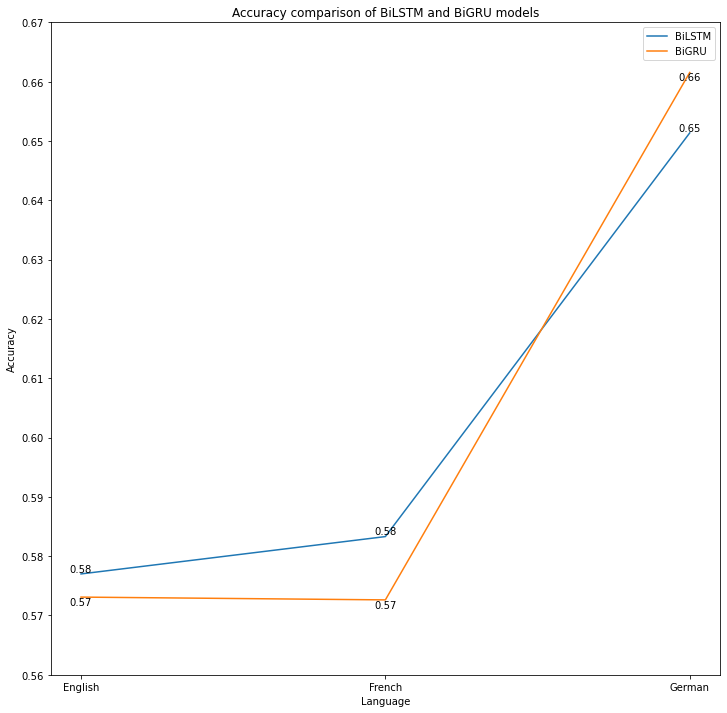

In [32]:
import matplotlib.pyplot as plt

# Define the accuracies for each language and model
languages = ["English", "French", "German"]
bilstm_acc = [BiLSTM_english_accuracy, BiLSTM_french_accuracy, BiLSTM_german_accuracy]
bigru_acc = [BiGru_english_accuracy, BiGru_french_accuracy, BiGru_germa_accuracy]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the BiLSTM and BiGRU accuracies as two lines
ax.plot(languages, bilstm_acc, label="BiLSTM")
ax.plot(languages, bigru_acc, label="BiGRU")

# Add labels and a legend
ax.set_xlabel("Language")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy comparison of BiLSTM and BiGRU models")
ax.legend()

ax.set_ylim([0.56, 0.67])
ax.set_yticks([0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67])

for i, acc in enumerate(bilstm_acc):
    ax.text(languages[i], acc, f"{acc:.2f}", ha="center", va="bottom")

for i, acc in enumerate(bigru_acc):
    ax.text(languages[i], acc, f"{acc:.2f}", ha="center", va="top")

# Display the plot
plt.show()


In [9]:

test_data = pd.read_csv("French test.csv")
test_context1 = test_data["Column7"].astype(str).tolist()
test_context2 = test_data["Column8"].astype(str).tolist()


test_context1_seq = tokenizer.texts_to_sequences(test_context1)
test_context2_seq = tokenizer.texts_to_sequences(test_context2)

test_context1_seq = pad_sequences(test_context1_seq, maxlen=max_len, padding="post", truncating="post")
test_context2_seq = pad_sequences(test_context2_seq, maxlen=max_len, padding="post", truncating="post")

test_input = np.concatenate((test_context1_seq, test_context2_seq), axis=1)


BiLSTM_predictions = BiLSTM_french.predict(test_input)
BiLSTM_predicted_labels = np.argmax(BiLSTM_predictions, axis=1)


BiGRU_predictions = BiGru_french.predict(test_input)
BiGRU_predicted_labels = np.argmax(BiGRU_predictions, axis=1)

test_data["BiLSTM_Predicted_Labels"] = BiLSTM_predicted_labels
test_data["BiGRU_Predicted_Labels"] = BiGRU_predicted_labels


print("BiLSTM Predicted Labels:")
print(BiLSTM_predicted_labels)

print("BiGRU Predicted Labels:")
print(BiGRU_predicted_labels)

test_data


695/695 [==============================] - 13s 19ms/step
BiLSTM Predicted Labels:
[0 1 0 ... 0 0 1]
BiGRU Predicted Labels:
[0 1 0 ... 0 0 1]


,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,BiLSTM_Predicted_Labels,BiGRU_Predicted_Labels
0,palpe,N,0,6,4,10,Palpes maxillaires et palpes labiales.,Les palpes d’un hanneton.,0,0
1,paravent,N,29,37,0,8,Se servir de quelqu’un comme paravent.,"Paravent chinois. — Paravent d’étoffe, de tapi...",1,1
2,attirer,V,22,29,15,21,L’aimant a la vertu d’attirer le fer.,L’ambre frotté attire les corps légers non mét...,0,0
3,débat,N,75,80,19,25,"La réal-politique peut donc, par cet exécutoir...","Ouvrir, fermer les débats. — La clôture des dé...",0,0
4,règle,N,113,118,10,15,"Il offre des sacrifices, aux autres dieux selo...",Suivre la règle. — Se conformer à la règle.,0,0
...,...,...,...,...,...,...,...,...,...,...
22227,errer,V,32,37,29,34,"Il n’y a personne qui ne puisse errer, qui ne ...","Si je me trompe, laissez-moi errer.",0,0
22228,aimer,V,21,27,11,16,Deux personnes qui s’aiment tendrement.,Le temps d’aimer.,0,0
22229,poldériser,V,89,99,43,53,Le tableau suivant fournit le détail des dépen...,"Au XIe siècle, on a commencé à endiguer et pol...",0,0
22230,transnosographie,N,0,16,0,16,Transnosographie du syndrome S.,"Transnosographie, la crise suicidaire (le fait...",0,0
